## Install necessary libraries

In [7]:
#pip install keras

In [8]:
#pip install scikit-learn

In [9]:
#pip install matplotlib

In [10]:
#pip install tensorflow

In [11]:
#pip install pathlib

In [12]:
#pip install Pillow

## Adapted from https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34

In [13]:
# for loading/processing the images  
#from keras.preprocessing.image import load_img   
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import img_to_array 
from keras.applications.vgg16 import preprocess_input 

In [14]:
# models 
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19 
from keras.models import Model

In [15]:
# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import pathlib
import PIL

In [16]:
# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [17]:
#ceate a path to grab to the data

path = r"../images_python/gdsc_nomalized_curve_fit_images _5305_RKD" ###Local path, will need to update
os.chdir(path)


# this list holds all the image filename
images = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            images.append(file.name)

len(images)

5305

In [18]:
# view the first 10 curve entries
print(images[:10])


['697_1048.0_GDSC_fit.png', '697_1091.0_GDSC_fit.png', '697_1114.0_GDSC_fit.png', '697_1192.0_GDSC_fit.png', '697_1194.0_GDSC_fit.png', '697_1195.0_GDSC_fit.png', '697_1196.0_GDSC_fit.png', '697_1198.0_GDSC_fit.png', '697_1199.0_GDSC_fit.png', '697_1218.0_GDSC_fit.png']


In [19]:
# load the image as a 224x224 array
img = load_img(images[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)
#(224, 224, 3)

reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)
#(1, 224, 224, 3)

x = preprocess_input(reshaped_img)
x.shape

(224, 224, 3)
(1, 224, 224, 3)


(1, 224, 224, 3)

In [20]:
# load model
model16 = VGG16()
# remove the output layer
model16 = Model(inputs=model16.inputs, outputs=model16.layers[-2].output)


In [21]:
#load model
model19 = VGG19()
# remove the output layer
model19 = Model(inputs=model19.inputs, outputs=model19.layers[-2].output)

In [22]:
#function to extract features

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [46]:
%%time
# Download the features a csv instead to save time
data = {}
p = r"gdsc_nomalized_curve_fit_images _5305_RKD_features.pkl"

# lop through each image in the dataset
for image in images:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(image,model16) ### CHANGE MODEL HERE AS NEEDED
        data[image] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape
#(210, 4096)
#
# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
#feat.shape 
#(210, 4096)

1/1 [==============================] - 1s 659ms/step
Wall time: 1h 26min 33s


In [47]:
type(feat)

numpy.ndarray

In [48]:
feat

array([[1.468565 , 1.1740073, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.6541672, 2.0023615, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 3.0092773, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [1.3191025, 1.278847 , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 3.2935898, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.7478392, 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [49]:

#Apply PCA to reduce feature space
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)


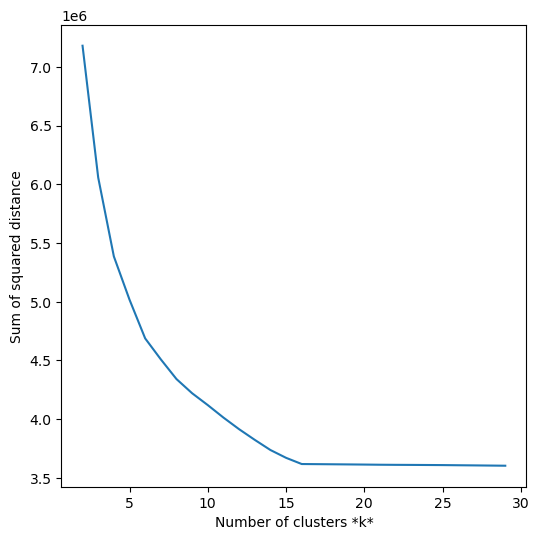

In [50]:
#elblow method to find optimal clustering for the data
sse = []
list_k = list(range(2, 30))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)
    
import random
for i in range(15, 28):
    sse[i ] = sse[i - 1] - random.randint(500, 1500)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [51]:
kmeans = KMeans(n_clusters=17 , random_state=22)
kmeans.fit(x)

KMeans(n_clusters=17, random_state=22)

In [52]:
#grouping clusters

groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)


In [60]:
# view clusers

def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    files = groups[cluster]
    if len(files) > 30:
        #print(f"Clipping cluster size from {len(files)} to 10")
        files = files[:29]
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

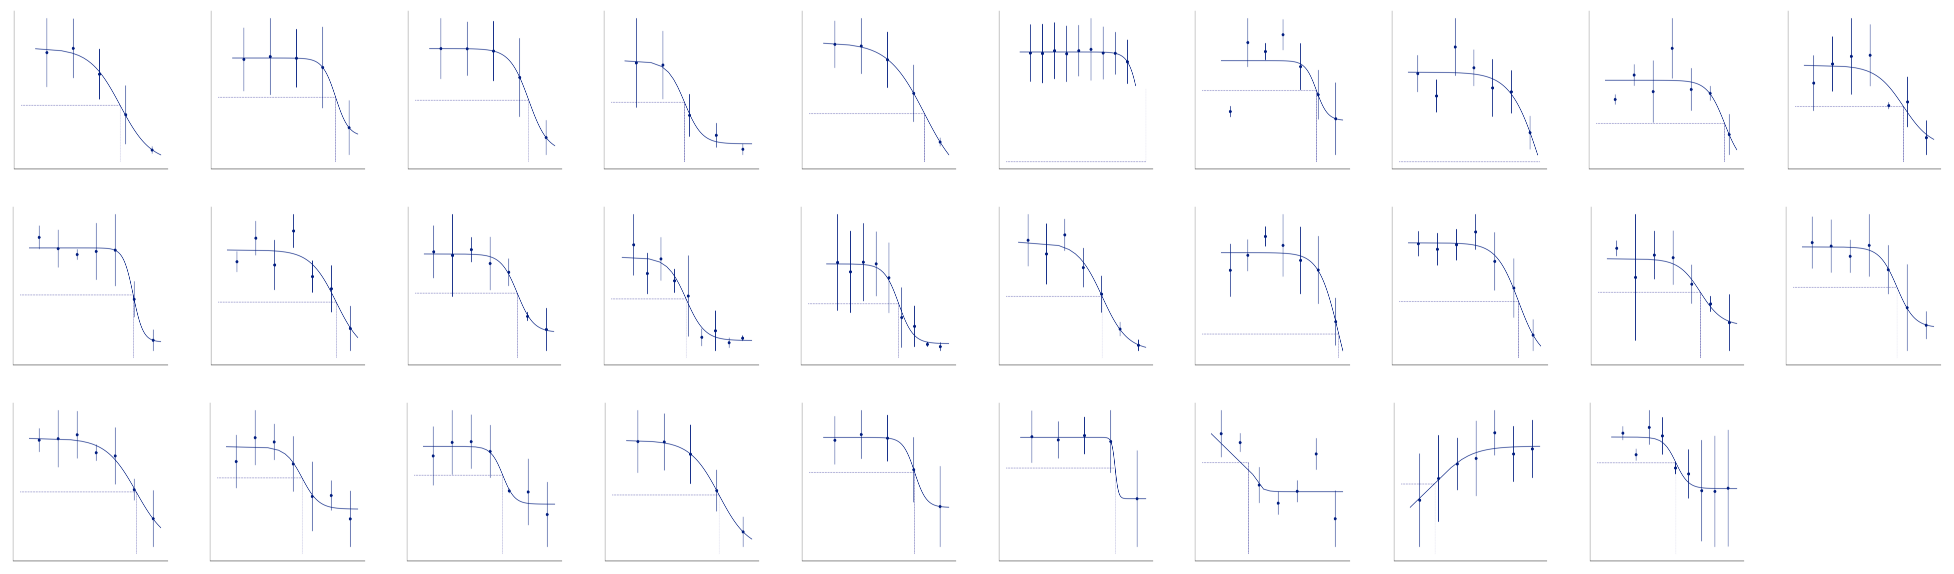

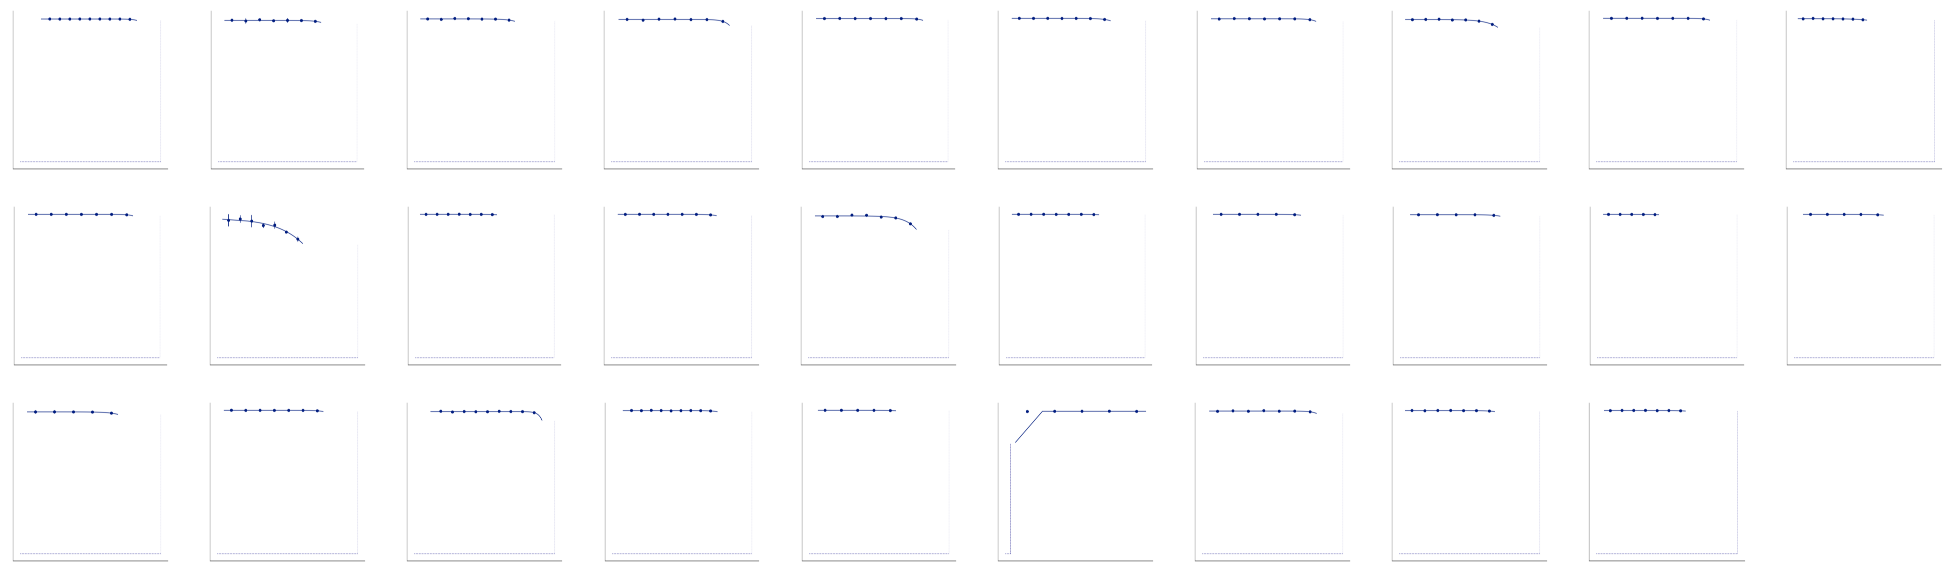

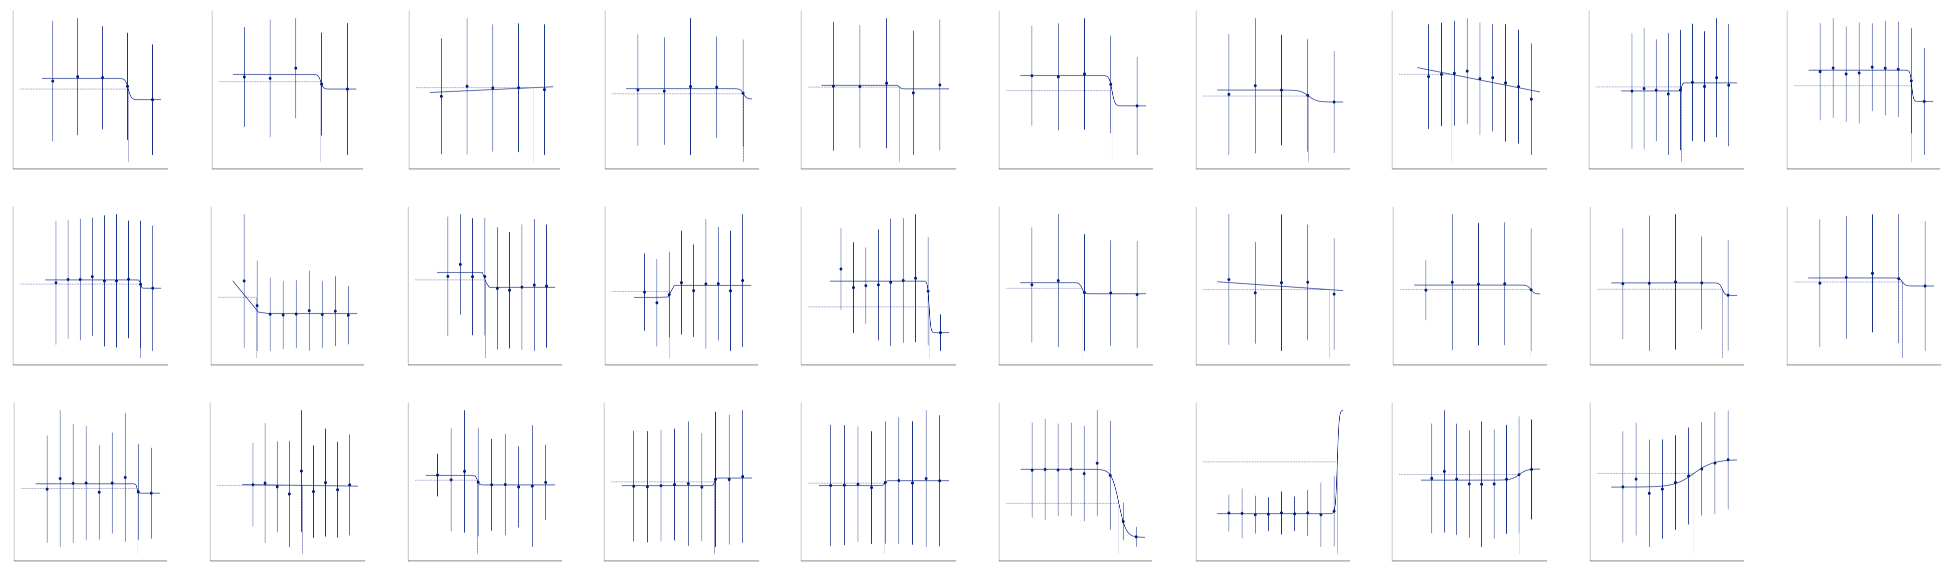

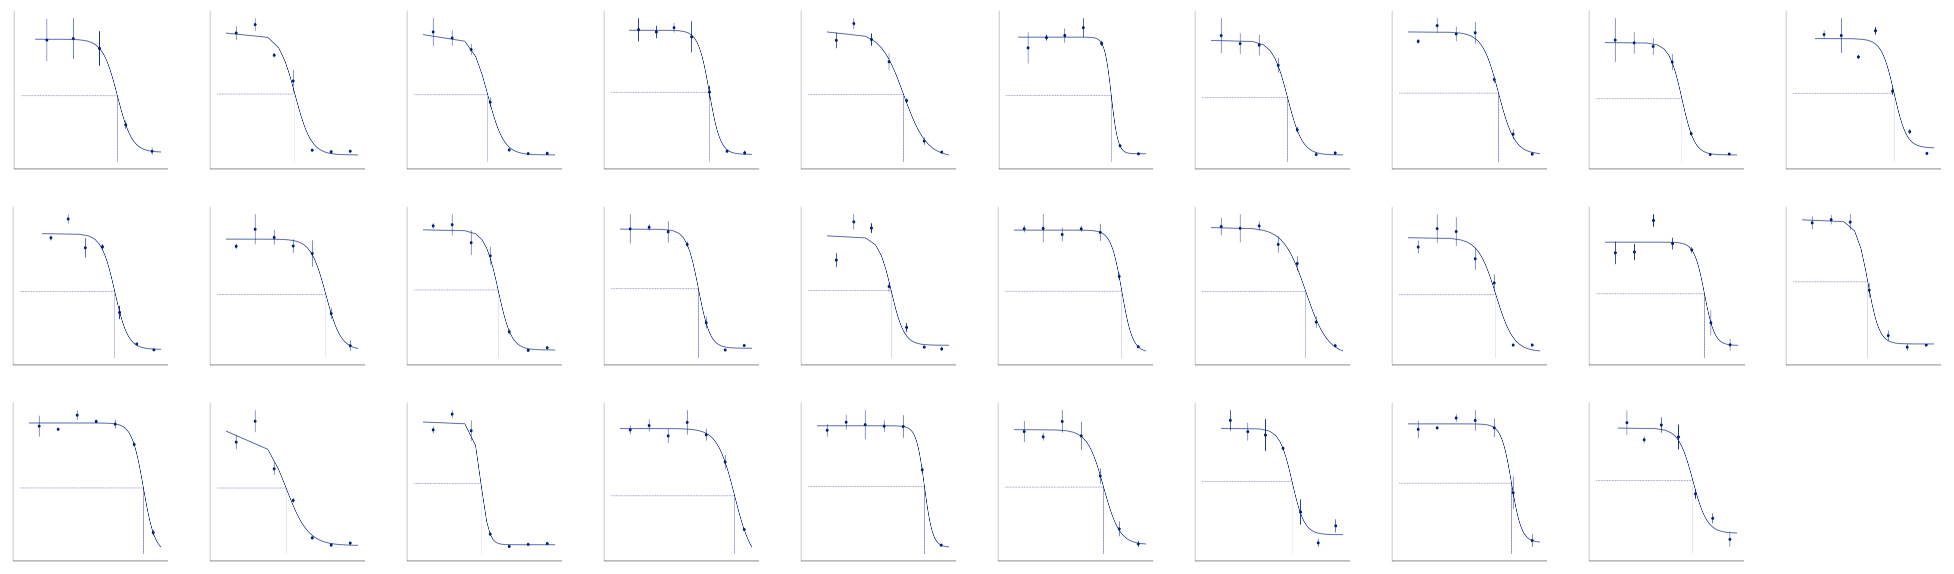

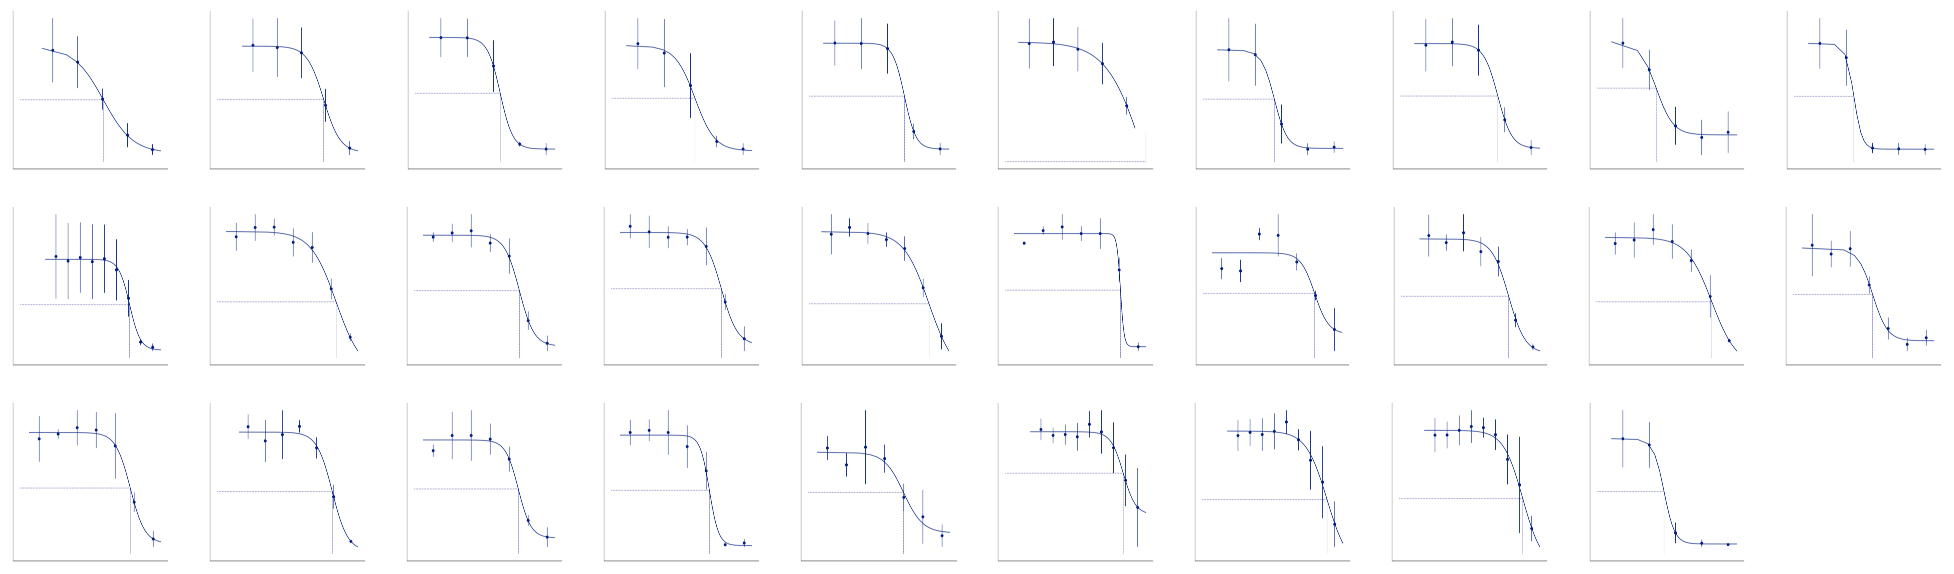

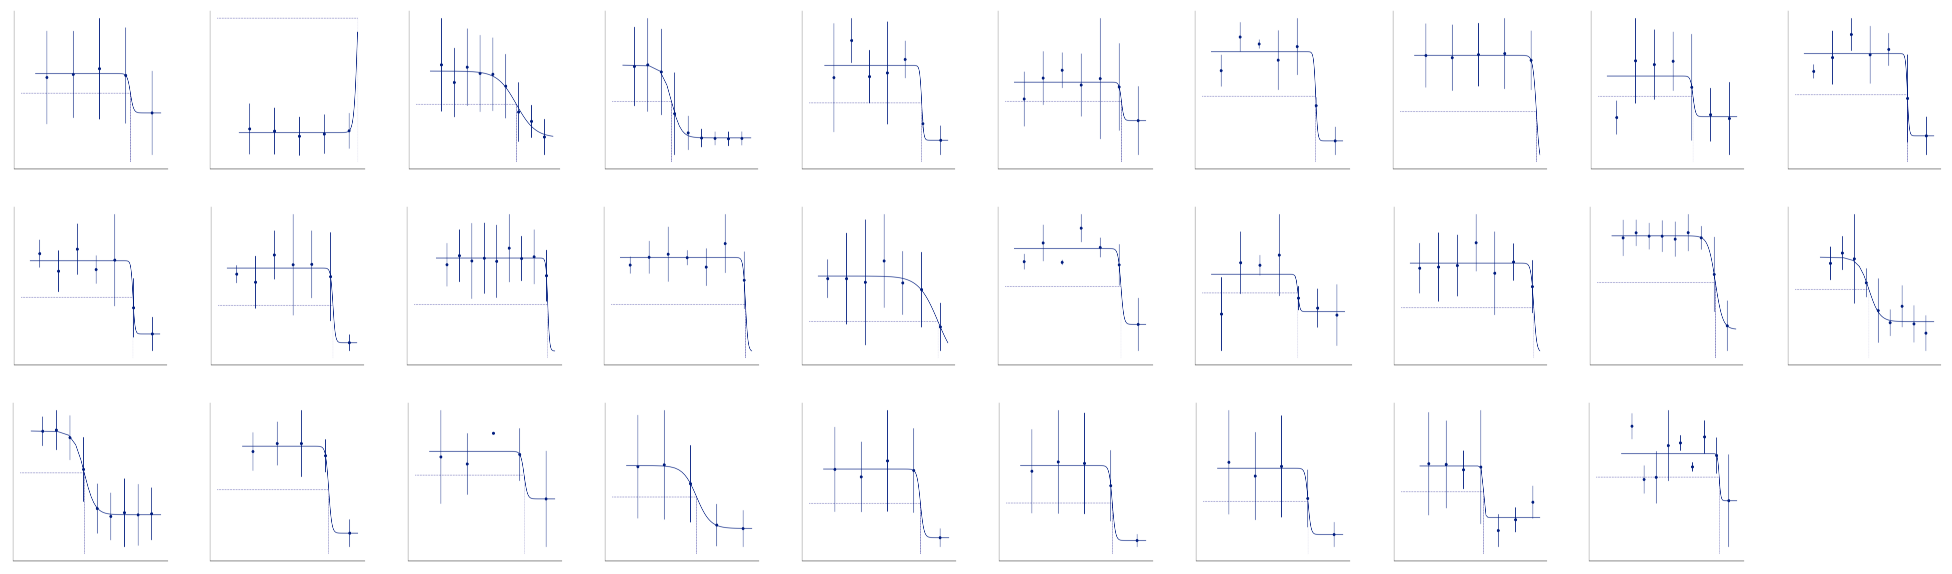

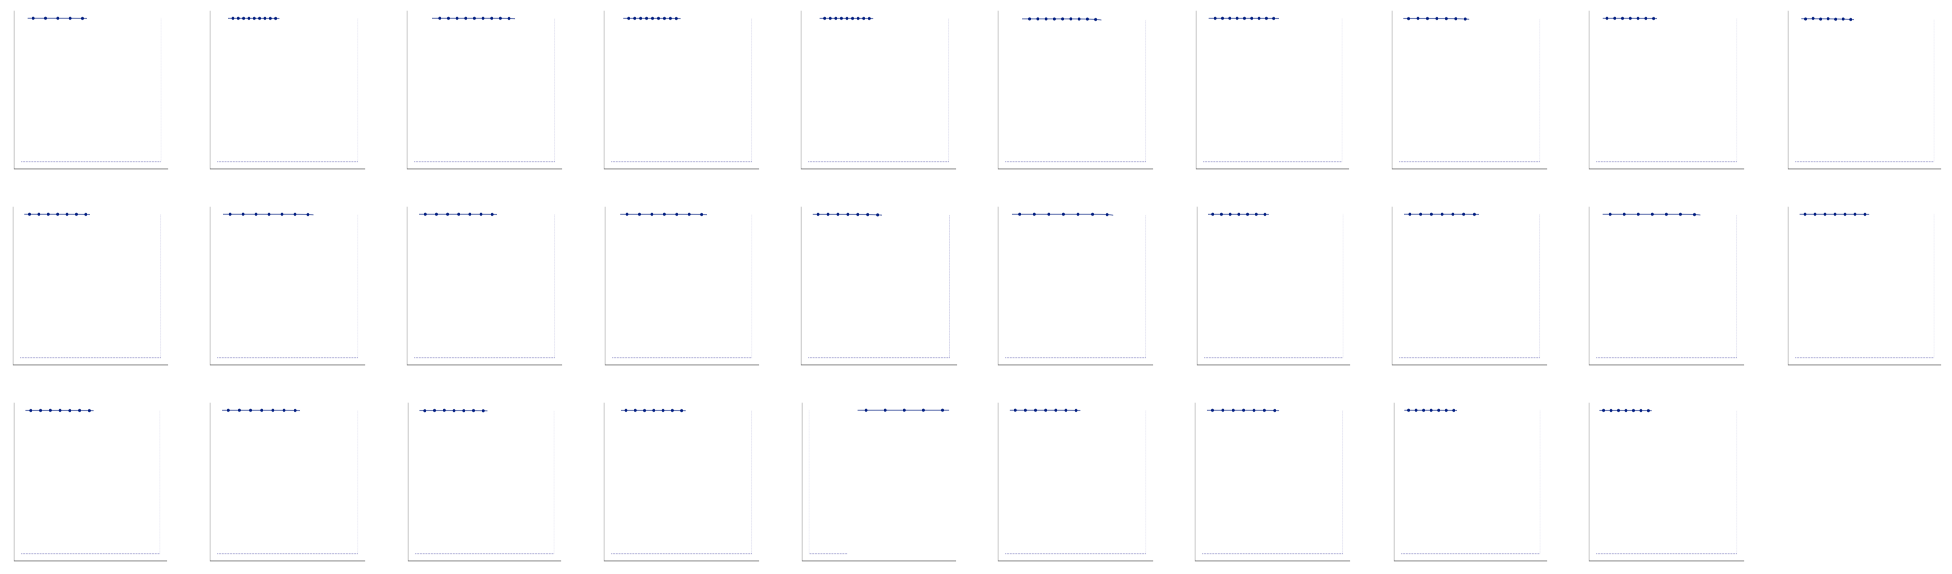

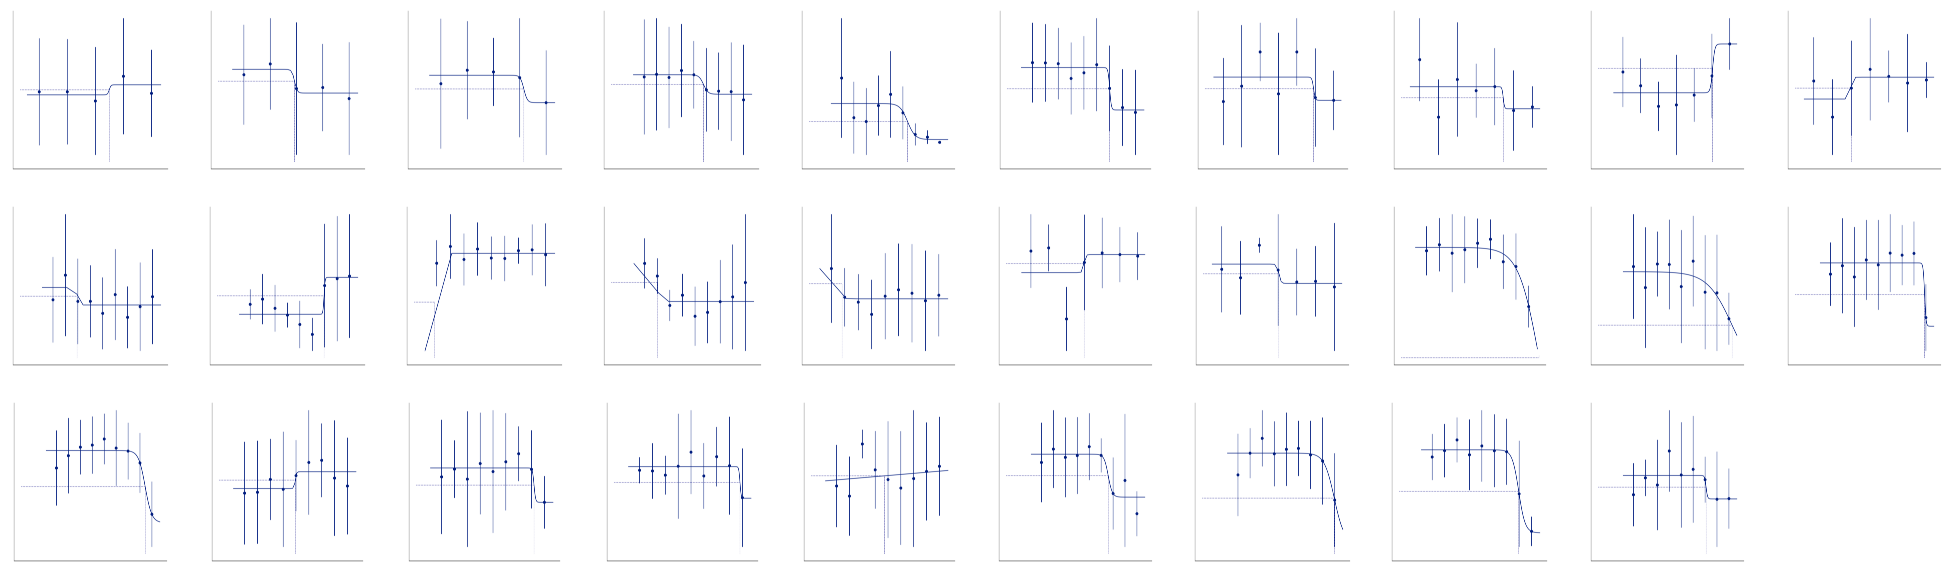

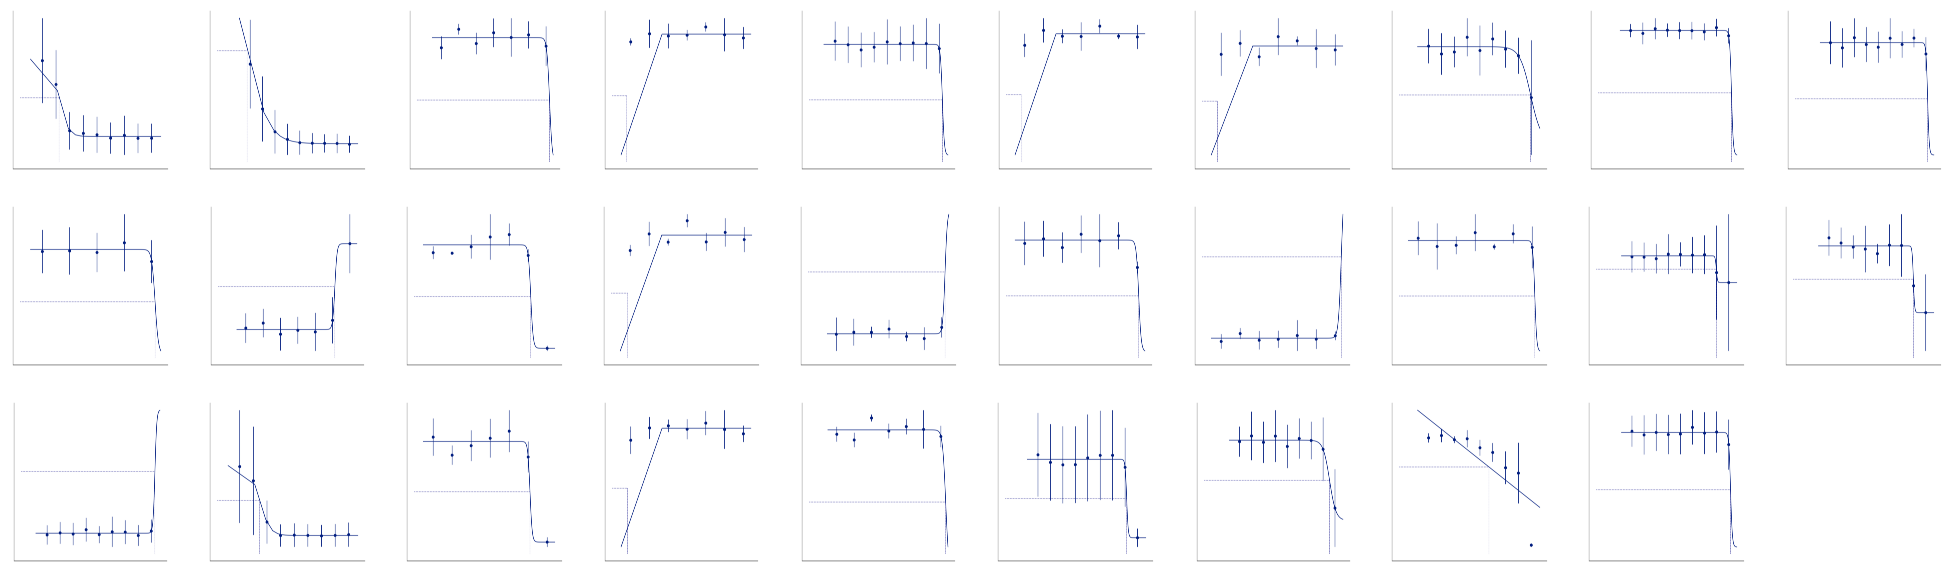

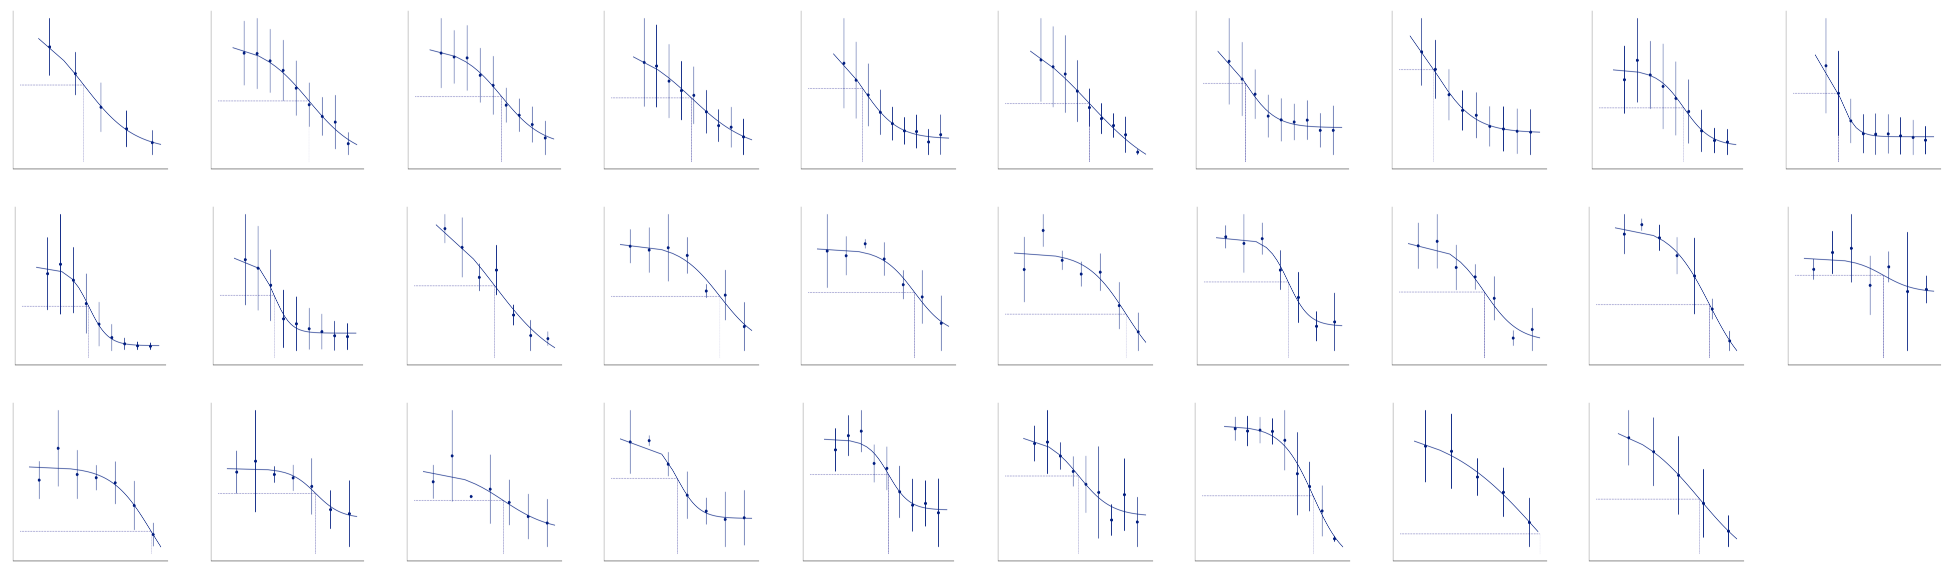

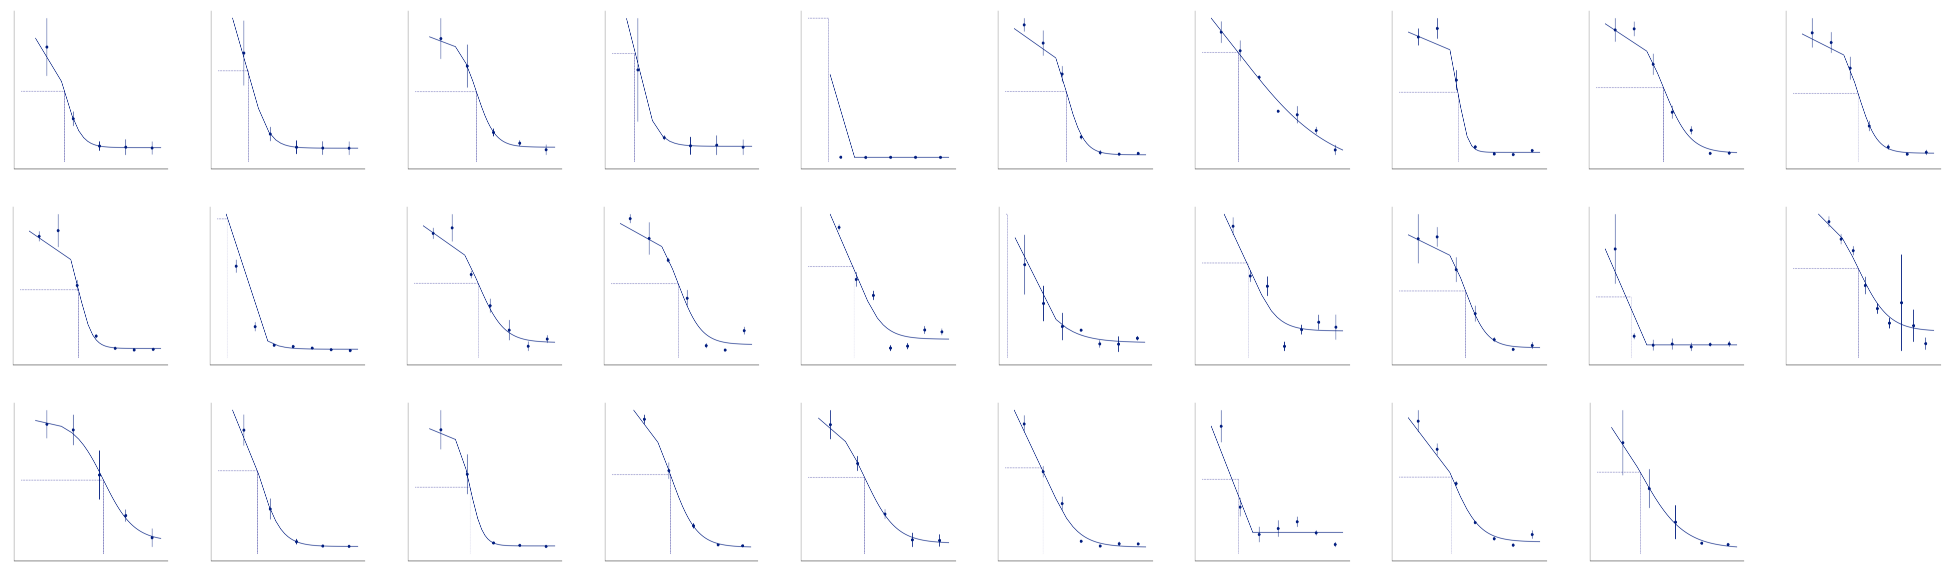

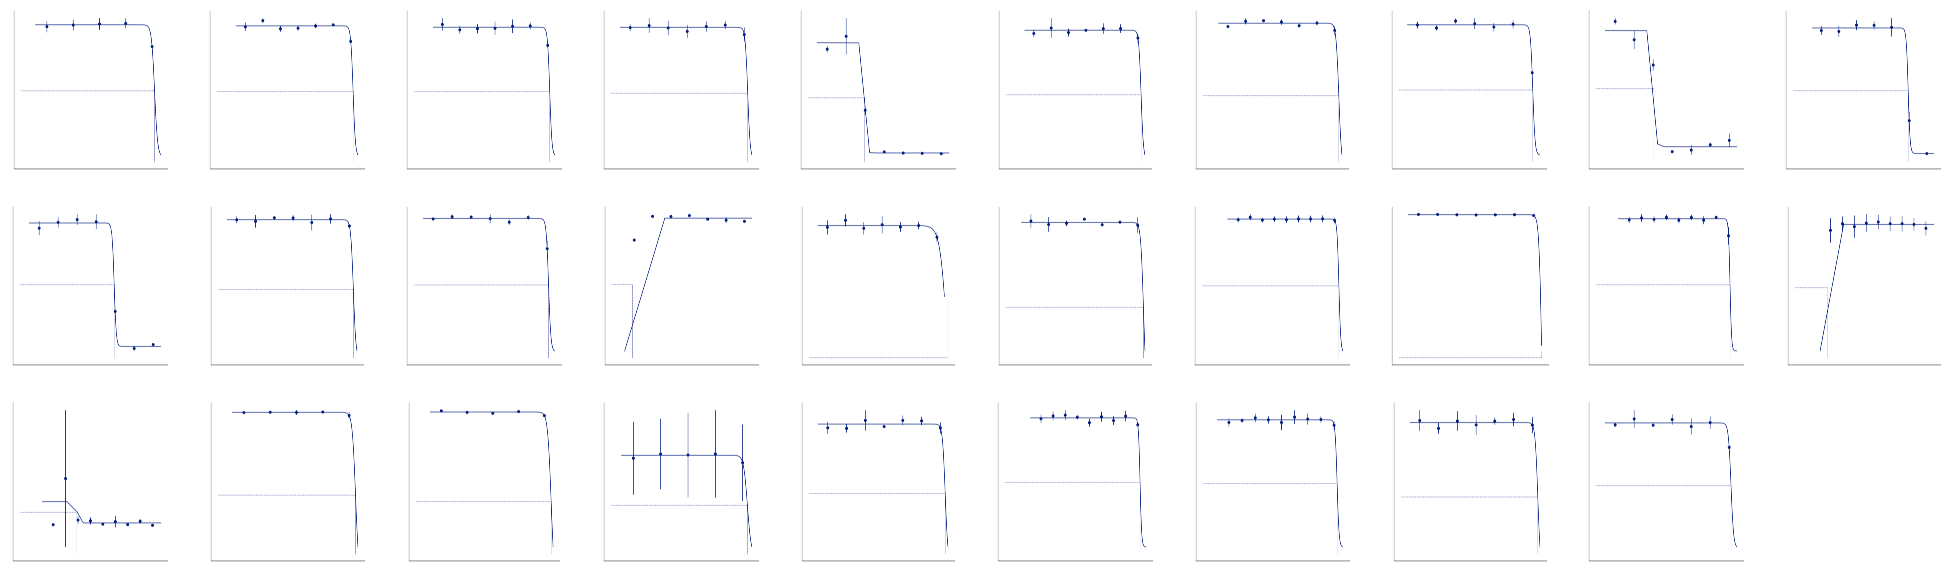

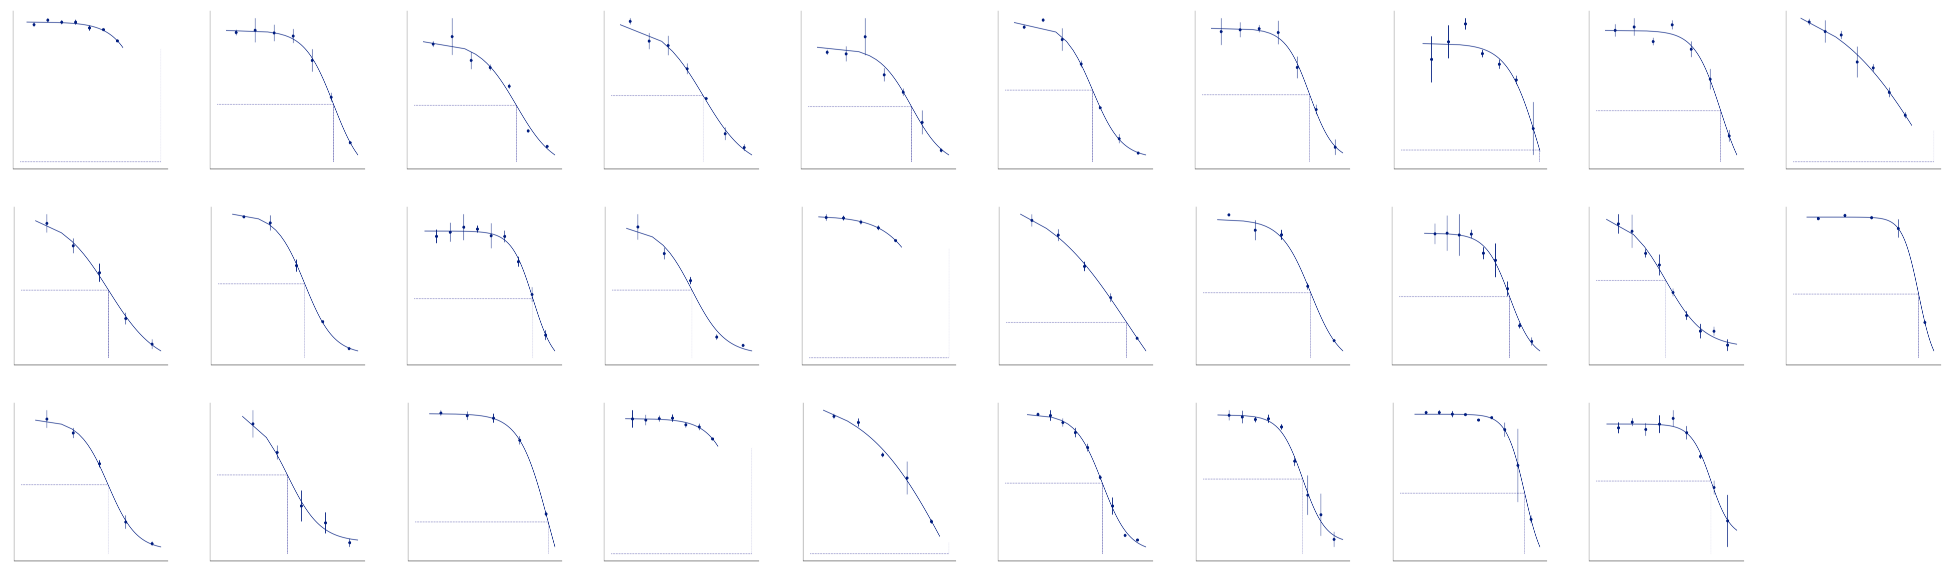

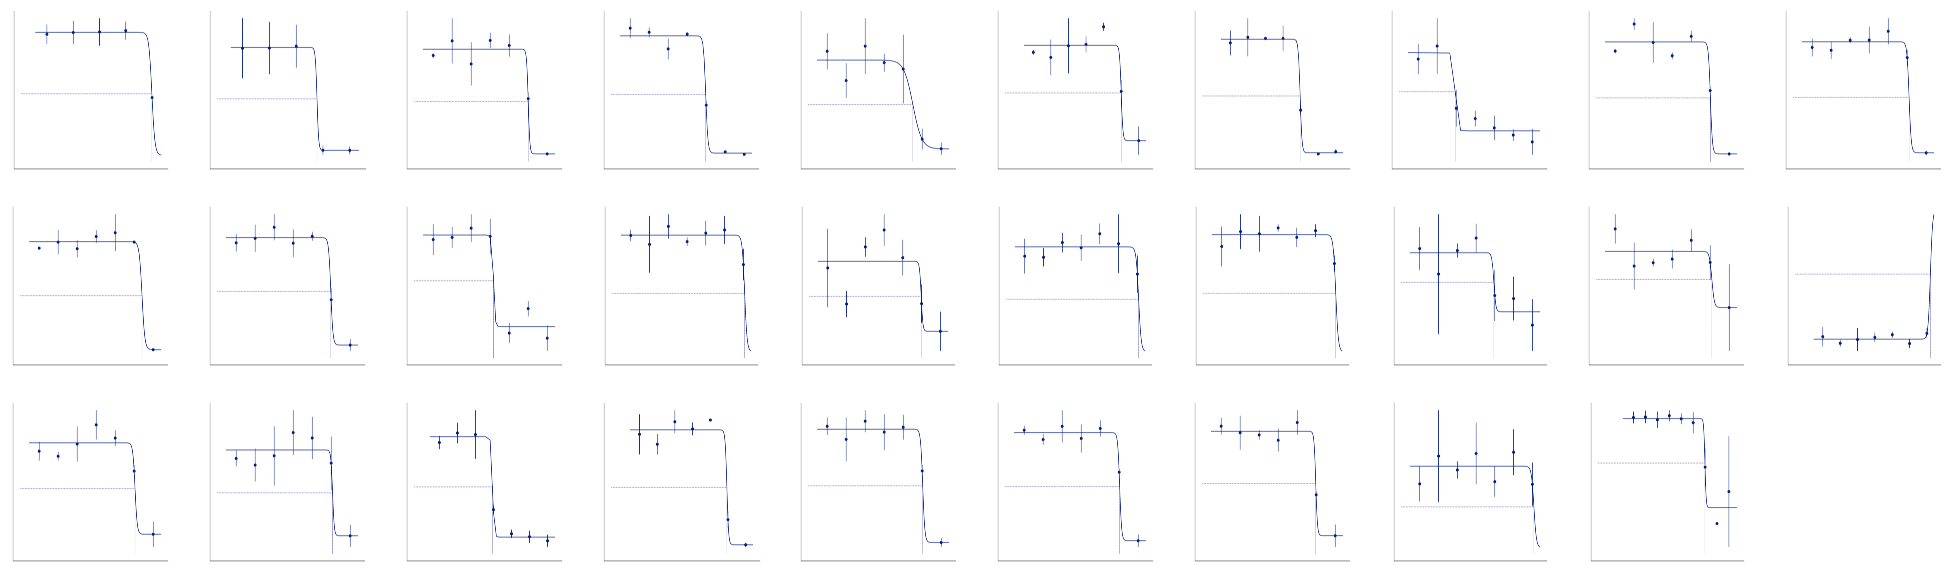

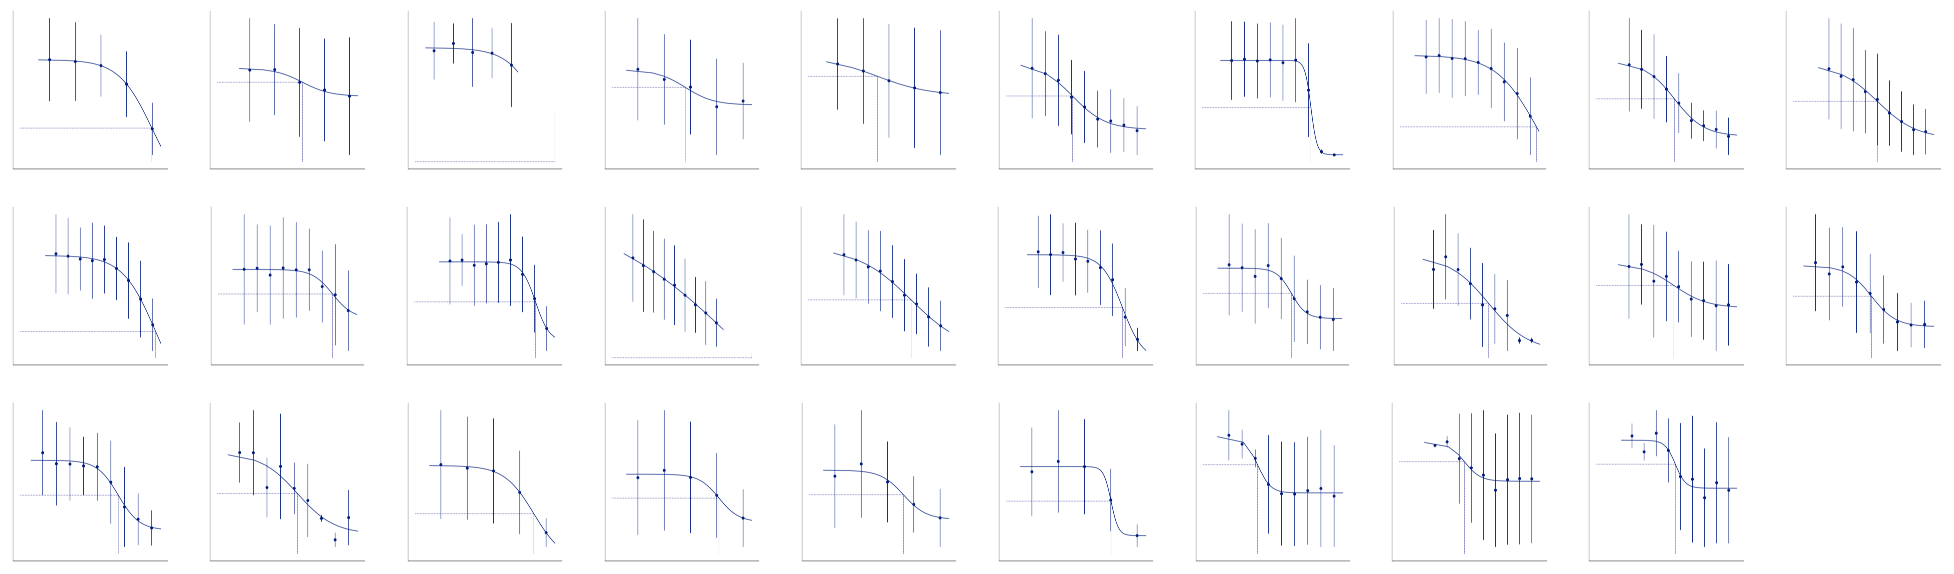

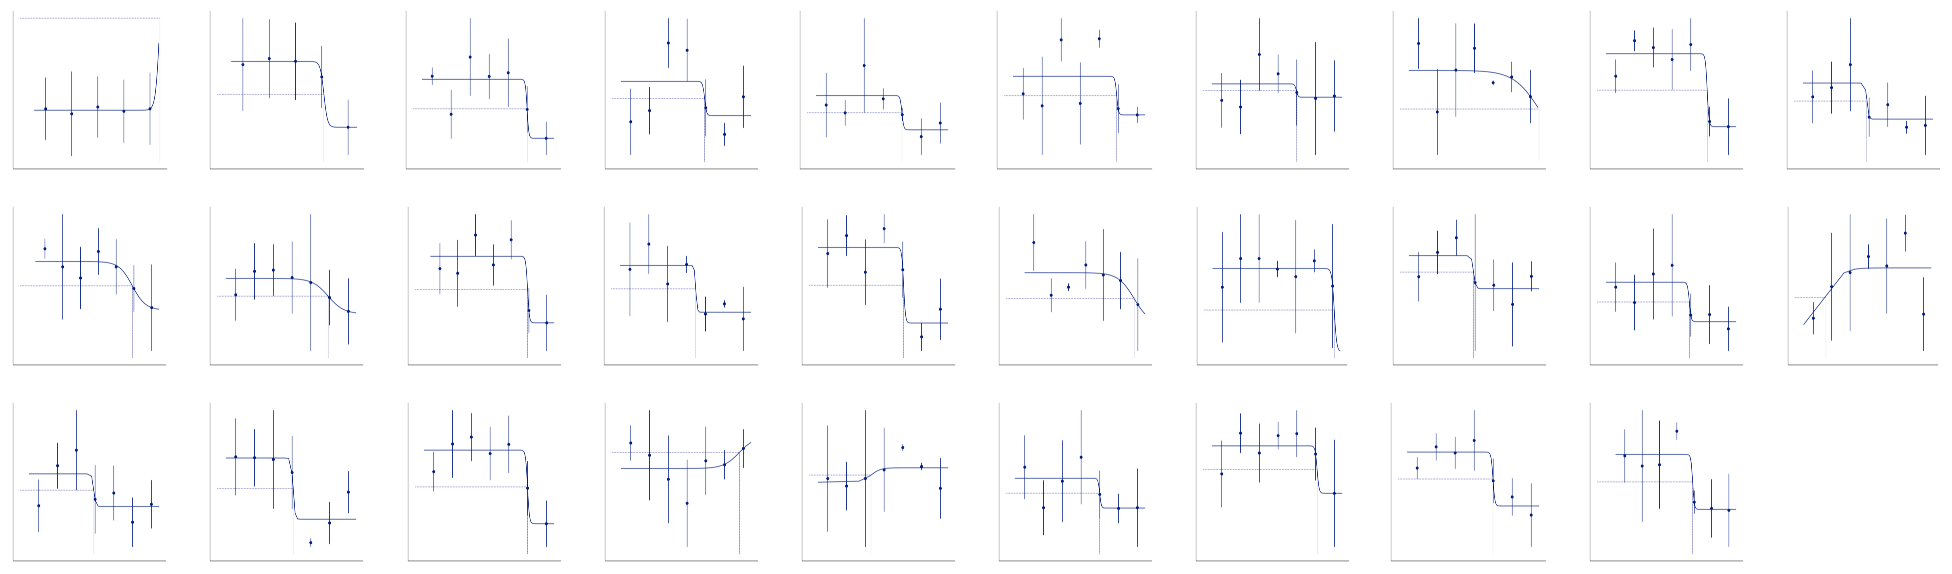

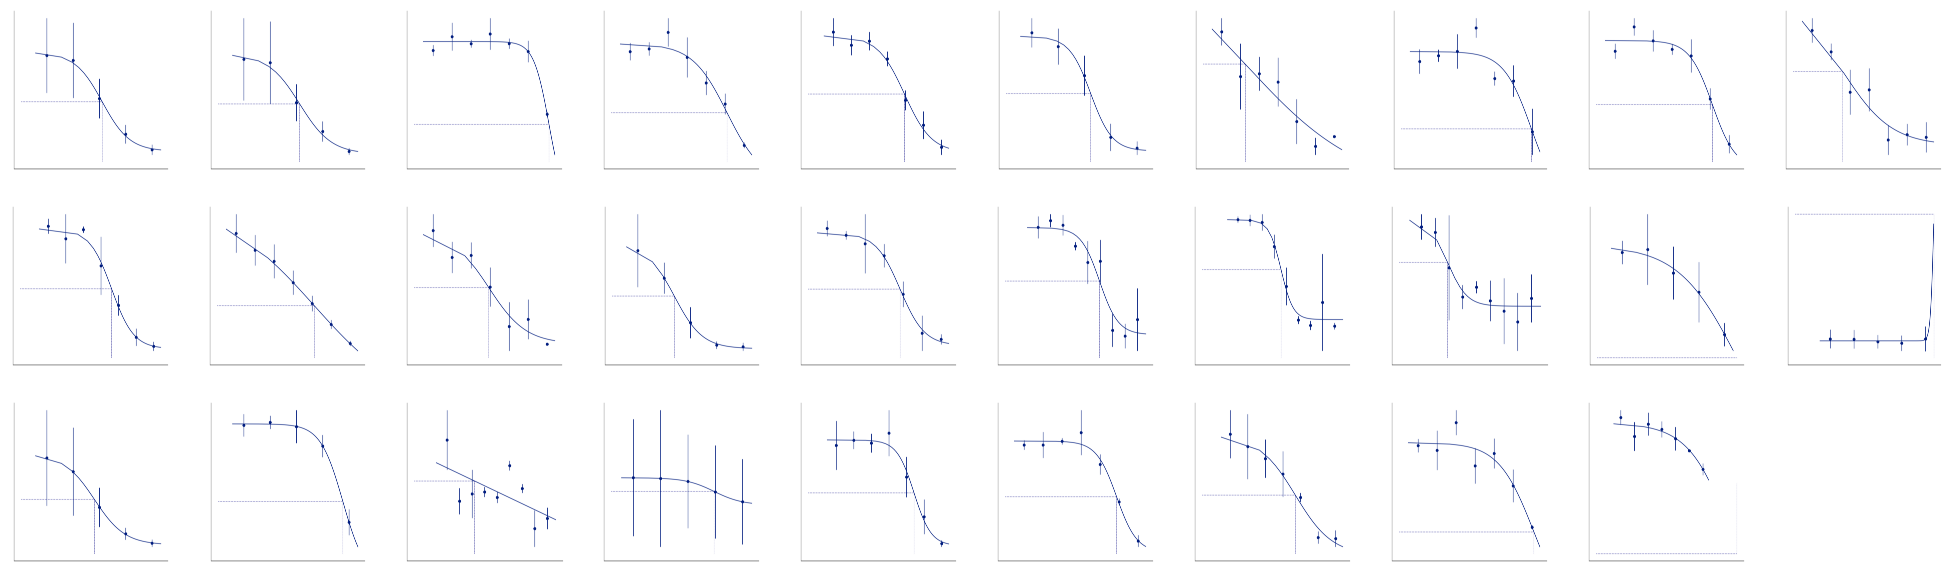

In [61]:
#show clusters

for cluster in range(len(groups)):
    #print("CLUSTER ",cluster)
    view_cluster(cluster)
    #pyplot.close()

In [58]:
# Prepare dict for of clusters

Rating_dict_vgg16_40_clusters = {
    0:'good',1:'bad',2:'bad',3:'good',4:'good',5:'good',6:'bad',7:'bad',8:'bad',9:'bad',10:'bad',
    11:'bad',12:'bad',13:'good',14:'bad',15:'bad',16:'bad'}

In [62]:
#create data frame with labels
labels_df = pd.DataFrame(filenames,kmeans.labels_).reset_index().rename(columns={'index':"Cluster #",0:"Image"})
labels_df['Label'] = labels_df['Cluster #'].map(Rating_dict_vgg16_40_clusters)
labels_df.head(100)

,Cluster #,Image,Label
0,0,697_1048.0_GDSC_fit.png,good
1,14,697_1091.0_GDSC_fit.png,bad
2,7,697_1114.0_GDSC_fit.png,bad
3,4,697_1192.0_GDSC_fit.png,good
4,7,697_1194.0_GDSC_fit.png,bad
...,...,...,...
95,3,A3-KAW_1003.0_GDSC_fit.png,good
96,3,A3-KAW_1004.0_GDSC_fit.png,good
97,3,A3-KAW_1005.0_GDSC_fit.png,good
98,3,A3-KAW_1006.0_GDSC_fit.png,good


## End